# Initialisation and Dependencies

In [1]:
import sys
lib_path = '/home/jovyan/libs'
sys.path.insert(0, lib_path)

In [2]:
import gc, math, traceback, os, datetime, logging
from typing import Callable, Union, Optional
from functools import partial
from abc import ABC, abstractmethod

import numpy as np
import matplotlib.pyplot as plt
from matplotlib import colormaps

import torch
import torchaudio
import torch.nn.functional as F
from torch.utils.data import DataLoader, Dataset, random_split
from torch.utils.tensorboard import SummaryWriter

from IPython.display import Audio, display

from datasets import load_dataset, load_from_disk

import whisper
from whisper.audio import N_FRAMES, N_SAMPLES
from whisper.tokenizer import get_tokenizer

from scipy.signal import butter, lfilter

from tqdm import tqdm

# GPU RAM Tracking

In [3]:
def print_cuda_usage(msg: str = ""):
    if torch.cuda.is_available():
        print(f"{msg}{torch.cuda.memory_allocated(0)/(1024 ** 3)} GB")

def get_cuda_usage():
    return torch.cuda.memory_allocated(0)/(1024 ** 3)

In [4]:
if torch.cuda.is_available():
    device = "cuda"
else:
    device = "cpu"

In [5]:
device

'cuda'

# Load Model

In [6]:
try:
    del model
    print("Model deleted!")
except:
    pass

In [7]:
MODEL_NAME = "small.en"

model = whisper.load_model(MODEL_NAME).to(device)
model.eval();

/home/jovyan/libs/whisper/__init__.py:150: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(fp, map_location=device)


In [8]:
tokenizer = get_tokenizer(model.is_multilingual, num_languages=model.num_languages, language="en", task="transcribe")
sot_ids = torch.tensor(tokenizer.sot_sequence_including_notimestamps, requires_grad=False)

# Load Data

In [9]:
tedlium_path = "./tedlium"
train_path, validation_path, test_path = f"{tedlium_path}/train.hf", f"{tedlium_path}/validation.hf", f"{tedlium_path}/test.hf"

In [10]:
TRAIN_SELECT = 500
VALID_SELECT = 150
TEST_SELECT = 250

SEED = 1

tedlium_train = load_from_disk(train_path).with_format("torch").shuffle(seed=SEED).select(range(TRAIN_SELECT))
tedlium_validation = load_from_disk(validation_path).with_format("torch").shuffle(seed=SEED).select(range(VALID_SELECT))
tedlium_test = load_from_disk(test_path).with_format("torch").shuffle(seed=SEED).select(range(TEST_SELECT))

Loading dataset from disk:   0%|          | 0/109 [00:00<?, ?it/s]

In [11]:
def collate(ls):
    pad_to = max(list(map(lambda x: x["audio"].shape[0], ls)))
    return torch.cat(list(map(lambda x: F.pad(x["audio"], (0, pad_to - x["audio"].shape[0])).unsqueeze(0).to(torch.bfloat16), ls)), dim=0)

TRAIN_BATCH_SIZE = 1 # highly recommended to be 1
VALID_BATCH_SIZE = 75

train_dataset = DataLoader(tedlium_train, batch_size=TRAIN_BATCH_SIZE, collate_fn=collate)
validation_dataset = DataLoader(tedlium_validation, batch_size=VALID_BATCH_SIZE, collate_fn=collate)
test_dataset = DataLoader(tedlium_test)

# Training Loop Helpers

In [12]:
"""
Helpers involving model interaction and loss

General flow is Audio Tensor --> Mel Tensor --> model.forward --> Logits --> Get log probabilities
"""

def audio_to_mel(audio: torch.Tensor) -> torch.Tensor:
    return whisper.pad_or_trim(whisper.log_mel_spectrogram(audio, padding=N_SAMPLES),
                              N_FRAMES)

def audio_to_mel_batch(audio_batch: torch.Tensor) -> torch.Tensor:
    if len(audio_batch.shape) == 1:
        audio_batch = audio_batch.unsqueeze(0)
    return torch.stack([audio_to_mel(audio) for audio in audio_batch])

def mel_to_logits_batch(model: whisper.model.Whisper, mel_batch: torch.Tensor, sot_ids: torch.Tensor) -> torch.Tensor:
    sot_ids = sot_ids.unsqueeze(0).expand(mel_batch.size(0), -1).to(device)
    return model.forward(mel_batch, sot_ids)

def get_loss_batch(logits: torch.Tensor, token_id: torch.Tensor) -> torch.Tensor:
    sf = torch.nn.Softmax(dim=1)
    log_probs = torch.log(sf(logits))
    tgt_probs = log_probs[:,token_id].squeeze()
    return -1 * torch.mean(tgt_probs)

In [13]:
"""
Utils to view mel
"""

def view_mel(audio: torch.Tensor) -> None:
    mel = whisper.log_mel_spectrogram(audio)
    plt.figure(figsize=(20, 4))
    plt.axis("off")
    plt.imshow(mel)
    plt.show()
    return

def mel_image(audio: torch.Tensor, pseudocolor_map: str = "Blues") -> torch.Tensor:
    image = whisper.log_mel_spectrogram(audio.squeeze())
    cm = colormaps[pseudocolor_map]
    return torch.tensor(cm(image))

In [14]:
"""
Other utils
"""

# unused
# def validate(model: whisper.model.Whisper, snippet: torch.Tensor, validation: torch.Tensor, 
#              prepare_method, tokenizer: whisper.tokenizer.Tokenizer) -> torch.Tensor:
#     with torch.no_grad():
#         validation = validation.to(device)
#         attacked_data = prepare_method(snippet, validation)
#         mel = audio_to_mel_batch(attacked_data)
#         logits = mel_to_logits_batch(model, mel, sot_ids)[:,-1,:].squeeze(dim=1)
#         loss = get_loss_batch(logits, tokenizer.eot)
#         return loss

# check if any values in the snippet violate the clamp constraint
def violates_clamp(snippet: torch.Tensor, clamp_epsilon: float) -> bool:
    if clamp_epsilon:
        with torch.no_grad():
            return torch.any(torch.logical_or(snippet > clamp_epsilon, snippet < -clamp_epsilon))

In [15]:
"""
Audio Modification Helpers
- Butterworth High Pass and Low Pass filters
- Compressions (Mu Law and Inverse Mu Law for reversibility)
"""

def lowpass_filter(audio_tensor: torch.Tensor, cutoff: int, sampling_rate: int = 16_000, order: int = 5) -> torch.Tensor:
    b, a = butter(order, cutoff, btype="lowpass", fs=sampling_rate, analog=False)
    y = lfilter(b, a, audio_tensor)
    return torch.from_numpy(y).to(torch.float32)

def highpass_filter(audio_tensor: torch.Tensor, cutoff: int, sampling_rate: int = 16_000, order: int = 5) -> torch.Tensor:
    b, a = butter(order, cutoff, btype="highpass", fs=sampling_rate, analog=False)
    y = lfilter(b, a, audio_tensor)
    return torch.from_numpy(y).to(torch.float32)

################################################

def mu_law(audio_tensor: torch.Tensor, mu: int = 255) -> torch.Tensor:
    sign = torch.where(audio_tensor >= 0, 1, -1)
    return sign * torch.log(1 + mu * torch.abs(audio_tensor)) / math.log(1 + mu)

def inv_mu_law(audio_tensor: torch.Tensor, mu: int = 255) -> torch.Tensor:
    sign = torch.where(audio_tensor >= 0, 1, -1)
    return sign * (torch.tensor([mu + 1]).pow(torch.abs(audio_tensor)) - 1) / mu

def mu_comp_decomp(audio_tensor: torch.Tensor, mu: int = 255) -> torch.Tensor:
    return inv_mu_law(mu_law(audio_tensor, mu), mu)

In [16]:
"""
Audio saving, loading and playing
"""
def save_audio(audio_tensor: torch.Tensor, filename: str = "test.wav", sample_rate: int = 16_000) -> None:
    if len(audio_tensor.shape) == 1:
        audio_tensor = audio_tensor.unsqueeze(0)
    elif audio_tensor.size(0) != 1:
        raise ValueError(f"audio_tensor must be of dims (1, n), current dims are {audio_tensor.shape}")
    torchaudio.save(filename, audio_tensor.detach().to("cpu"), sample_rate)

def load_audio(filename: str = "test.wav") -> torch.Tensor:
    return torchaudio.load(filename)[0]

def play_audio(param: Union[torch.Tensor, str], filename: str = "test.wav", sample_rate: int = 16_000):
    if isinstance(param, torch.Tensor):
        save_audio(param, filename, sample_rate)
    display(Audio(filename))

# Attack Methods

## Normal Attacks

In [38]:
"""
every attack preparation method must:
1. inherit from PrepareMethod (an abstract class)
2. Override __call__

* each example can either be a batch of audio tensors (M, N) or a single audio tensor (1, N)
* the snippet must be of shape (1, N)
"""
class PrepareMethod(ABC):
    def __init__(self, snippet_size: tuple, name: str):
        assert len(snippet_size) == 2, f"Snippet must have 2 dimensions, currently has {len(snippet_size)} dims"
        assert snippet_size[0] == 1, f"Snippet must be of shape (1, N), currently of shape {snippet_size}"
        self.snippet_size = snippet_size
        self.name = name
    
    def check_dims(self, snippet, example, desired_dims=2):
        offenders = ""
        if len(snippet.shape) != desired_dims:
            offenders += f"Need snippet (dims {len(snippet.shape)}, shape {snippet.shape}) to be of dims {desired_dims}\n"
        if len(example.shape) != desired_dims:
            offenders += f"Need example (dims {len(example.shape)}, shape {example.shape}) to be of dims {desired_dims}\n"
        if offenders:
            raise ValueError(offenders.strip())
    
    @abstractmethod
    def __call__(self, snippet, example):
        pass
    
#################################

class PrepareFront(PrepareMethod):
    def __init__(self):
        super().__init__((1, 10240), "prepare_front")
    
    def __call__(self, snippet, example):
        self.check_dims(snippet, example)
        snippet = snippet.repeat(example.size(0), 1)
        return torch.cat([snippet, example], dim=1)

#################################

class PrepareOverlay(PrepareMethod):
    def __init__(self):
        super().__init__((1, 480_000), "prepare_overlay")
    
    def __call__(self, snippet, example):
        self.check_dims(snippet, example)
        example = F.pad(example, (0, snippet.size(1) - example.size(1)), "constant", 0)
        snippet = snippet.repeat(example.size(0), 1)
        return snippet + example
    
#################################

class PrepareOverlayFront(PrepareMethod):
    def __init__(self, snippet_size):
        super().__init__(snippet_size, "prepare_overlay_front")
    
    def __call__(self, snippet, example):
        self.check_dims(snippet, example)
        snippet = F.pad(snippet, (0, example.size(1) - snippet.size(1)), "constant", 0)
        snippet = snippet.repeat(example.size(0), 1)
        return snippet + example

## Mu-Law Attacks

In [18]:
#################################
                         
class PrepareFrontMu(PrepareMethod):
    def __init__(self):
        super().__init__((1, 480_000), "prepare_overlay_mu")
    
    def __call__(self, snippet, example):
        self.check_dims(snippet, example)
        example = F.pad(example, (0, snippet.size(1) - example.size(1)), "constant", 0)
        snippet = snippet.repeat(example.size(0), 1)
        return mu_law(torch.cat([snippet, example], dim=1))

#################################
                         
class PrepareOverlayMu(PrepareMethod):
    def __init__(self):
        super().__init__((1, 480_000), "prepare_overlay_mu")
    
    def __call__(self, snippet, example):
        self.check_dims(snippet, example)
        example = F.pad(example, (0, snippet.size(1) - example.size(1)), "constant", 0)
        snippet = snippet.repeat(example.size(0), 1)
        return mu_law(snippet + example)

## Pass-Filter Attacks

In [19]:
# TBI

## Unused Attacks

In [20]:
# Unused
def prepare_middle(snippet, example):
    check_dims(snippet, "snippet")
    check_dims(example, "example")
    fragment1, fragment2 = torch.tensor_split(example, 2, dis=1)
    snippet = snippet.repeat(example.size(0), 1)
    return torch.cat([fragment1, snippet, fragment2])

def prepare_back(snippet, example):
    check_dims(snippet, "snippet")
    check_dims(example, "example")
    snippet = snippet.repeat(example.size(0), 1)
    return torch.cat([example, snippet], dim=1)

def prepare_overlay(snippet, example):
    check_dims(snippet, "snippet")
    check_dims(example, "example")
    snippet = F.pad(snippet, (0, example.size(1) - snippet.size(1)), "constant", 0)
    snippet = snippet.repeat(example.size(0), 1)
    return snippet + example

# Training Loop

In [21]:
def training_autograd(model: whisper.model.Whisper,
                      train_data: torch.utils.data.DataLoader, valid_data: torch.utils.data.DataLoader,
                      prepare_method: PrepareMethod,
                      writer: SummaryWriter = None,
                      lr: float = 1e-3,
                      iter_limit: int = None, mins_limit: int = None, patience: int = None, clamp_epsilon: float = None) -> torch.Tensor:
    """
    Runs the training loop and returns learned adversarial snippet.

    Args:
        model (whisper.model.Whisper)             : Whisper model
        train_data (torch.utils.data.DataLoader)  : Training dataset
        valid_data (torch.utils.data.DataLoader)  : Validation dataset
        prepare_method (PrepareMethod)            : Preprocessing class that combines the adversarial snippet and the training data
        writer (SummaryWriter)                    : Writer for the Tensorboard (Default is None)
        lr (float)                                : Optimizer Learning Rate (Default is 1e-3)
        iter_limit (int)                          : Epoch limit (Default is None)
        mins_limit (int)                          : Time limit in minutes (Default is None)
        patience (int)                            : Patience for Early Stopping (Default is None)
        clamp_epsilon (float)                     : Value for L-Infinity clamping of the snippet. If None, does not clamp (Default is None)

    Returns:
        snippet (torch.Tensor)                    : Learned adversarial snippet
    """
    
    # initialise stuff
    torch.autograd.set_detect_anomaly(False)
    loss = torch.tensor(np.inf, requires_grad=True)
    num_training_batches = len(train_data)
    num_valid_batches = len(valid_data)

    time_limit = mins_limit * 60 if mins_limit else None

    snippet = torch.rand(prepare_method.snippet_size, requires_grad=True, device=device) # adversarial snippet
    if clamp_epsilon:
        with torch.no_grad():
            snippet = snippet * clamp_epsilon
    snippet.requires_grad = True

    optim = torch.optim.AdamW([snippet], lr=lr, weight_decay=0)
    scheduler = torch.optim.lr_scheduler.StepLR(optim, step_size=5, gamma=0.5)

    attack_stack, attacked_data, mel, logits, pbar, avg_valid_loss = None, None, None, None, None, None
    lowest_valid_loss = np.inf
    curr_patience = patience
    best_snippet = snippet.detach().clone()

    # display attack method and snippet for sanity check
    print(f"Prepare method: {prepare_method.name}")
    print(f"Snippet initialised to [{torch.min(snippet)}, {torch.max(snippet)}] of size {prepare_method.snippet_size}")
    print(f"Clamp: {clamp_epsilon}\nTime Limit (Mins): {mins_limit}\nEpochs Limit: {iter_limit}")

    # log attack snippet
    if writer:
        writer.add_image("Attack Snippet", mel_image(snippet.detach().to("cpu")), 0, dataformats="HWC")
        writer.flush()

    # progress bar
    pbar = tqdm(range(1), desc="Training", ncols=0)
    itera = 0

    # track gpu usage
    base_cuda_usage = get_cuda_usage()

    try:
        while True:
            itera += 1
            if iter_limit:
                iter_limit -= 1
                if iter_limit <= 0:
                    pbar.set_postfix_str("Epoch limit reached! Terminating...")
                    break
            if time_limit and pbar.format_dict["elapsed"] >= time_limit:
                pbar.set_postfix_str("Time limit reached! Terminating...")
                break
            if patience and avg_valid_loss:
                if curr_patience <= 0:
                    pbar.set_postfix_str("Patience expired! Terminating...")
                    break
            if clamp_epsilon and violates_clamp(snippet, clamp_epsilon):
                raise ValueError("Snippet values violate clamp constraint!!")

            avg_training_loss = 0
            avg_valid_loss = 0
            total_cuda_usage_iter = 0

            for batch_no, batch in enumerate(train_data):
                pbar.set_postfix_str(f"Iter {itera}, Training Batch {batch_no + 1}/{num_training_batches}")

                batch = batch.to(device)
                attacked_data = prepare_method(snippet, batch)

                # forward prop
                mel = audio_to_mel_batch(attacked_data)
                logits = mel_to_logits_batch(model, mel, sot_ids)[:,-1,:].squeeze(dim=1)
                loss = get_loss_batch(logits, tokenizer.eot)
                
                # get training metrics
                total_cuda_usage_iter += get_cuda_usage()
                avg_training_loss += loss.detach()

                # backprop
                optim.zero_grad()
                loss.backward()
                optim.step()
                
                # clamp snippet
                if clamp_epsilon:
                    with torch.no_grad():
                        snippet.clamp_(min=-clamp_epsilon, max=clamp_epsilon)
                        
                snippet.requires_grad = True
                batch.to("cpu")

            avg_training_loss /= len(train_data)

            # validation
            with torch.no_grad():
                for batch_no, v in enumerate(valid_data):
                    pbar.set_postfix_str(f"Iter {itera}, Validation Batch {batch_no + 1}/{num_valid_batches}")
                    v = v.to(device)
                    attacked_data_valid = prepare_method(snippet, v)
                    mel_valid = audio_to_mel_batch(attacked_data_valid)
                    logits_valid = mel_to_logits_batch(model, mel_valid, sot_ids)[:,-1,:].squeeze(dim=1)
                    avg_valid_loss += get_loss_batch(logits_valid, tokenizer.eot)
            avg_valid_loss /= num_valid_batches
            
            # track lowest valid loss and save the snippet with lowest valid loss
            if avg_valid_loss >= lowest_valid_loss:
                curr_patience -= 1
            else:
                curr_patience = patience
                lowest_valid_loss = avg_valid_loss
                best_snippet = snippet.detach().clone()

            pbar.write(f"Trng Avg Loss: {avg_training_loss} | Valid Avg Loss: {avg_valid_loss} | Patience: {curr_patience} | LR: {scheduler.get_last_lr()} | Epoch Limit: {iter_limit}")

            if writer:
              # log training and validation losses
                writer.add_scalar("Training average loss", avg_training_loss, itera)
                writer.add_scalar("Validation average loss", avg_valid_loss, itera)

                # log GPU RAM usage
                if torch.cuda.is_available():
                    writer.add_scalar("GPU RAM Usage", total_cuda_usage_iter / num_training_batches - base_cuda_usage, itera)

              # log attack snippet and flush
                writer.add_image("Attack Snippet", mel_image(snippet.detach().to("cpu")), itera, dataformats="HWC")
                writer.flush()
            
            # LR decay
            scheduler.step()
            
            # refresh pbar to (hopefully) force update of progress bar
            pbar.refresh()

    except Exception as e:
        # need to explicitly close pbar here so traceback can print error
        if pbar is not None:
            pbar.clear()
            pbar.close()
            traceback.print_exc()

    finally:
        # close pbar to free stdout/stdsys (cant rmb which one)
        if pbar is not None:
            pbar.clear()
            pbar.close()

        # clear tensors from GPU memory to
        # prevent memory leak
        if attacked_data is not None:
            attacked_data.to("cpu")
            del attacked_data
            print("Cleared attacked data")

        if attack_stack is not None:
            attack_stack.to("cpu")
            del attack_stack
            print("Cleared attack stack")

        if mel is not None:
            mel.to("cpu")
            del mel
            print("Cleared mel")

        if logits is not None:
            logits.to("cpu")
            del logits
            print("Cleared logits")

        loss.to("cpu")
        del loss
        print("Cleared loss")

        # empty GPU cache and garbage collect
        torch.cuda.empty_cache()
        gc.collect()
        print_cuda_usage()
        
        return best_snippet.detach().to("cpu")

In [22]:
gc.collect()
torch.cuda.empty_cache()
print_cuda_usage()

0.902857780456543 GB


In [47]:
LR = 1e-3
PATIENCE = 3
MIN_LIMIT = 45
ITER_LIMIT = 30
CLAMP_EP = 0.1
PREPARE_METHOD = PrepareOverlayFront((1, 16000))

writer = None

In [35]:
# tensorboard writer
timestamp = datetime.datetime.now().strftime(f'%Y%m%d-%H%M%S_clamp_{CLAMP_EP}_{PREPARE_METHOD.name}')
writer = SummaryWriter(log_dir=f"runs/clamp_tests/{timestamp}", max_queue=5)

In [ ]:
snippet = training_autograd(model, train_dataset, validation_dataset, 
                            PREPARE_METHOD,
                            writer, lr=LR, 
                            iter_limit=ITER_LIMIT, mins_limit=MIN_LIMIT, patience=PATIENCE, clamp_epsilon=CLAMP_EP)

Prepare method: prepare_overlay_front
Snippet initialised to [8.406781489611603e-06, 0.09999900311231613] of size (1, 16000)
Clamp: 0.1
Time Limit (Mins): 45
Epochs Limit: 30


Training:   0% 0/1 [02:24<?, ?it/s, Iter 2, Training Batch 2/500]  

Trng Avg Loss: 9.10246753692627 | Valid Avg Loss: 8.110187530517578 | Patience: 3 | LR: [0.001] | Epoch Limit: 29


Training:   0% 0/1 [03:39<?, ?it/s, Iter 3, Training Batch 2/500]  

Trng Avg Loss: 8.052210807800293 | Valid Avg Loss: 7.503369331359863 | Patience: 3 | LR: [0.001] | Epoch Limit: 28


Training:   0% 0/1 [04:54<?, ?it/s, Iter 4, Training Batch 2/500]  

Trng Avg Loss: 7.424419403076172 | Valid Avg Loss: 6.7608642578125 | Patience: 3 | LR: [0.001] | Epoch Limit: 27


Training:   0% 0/1 [06:08<?, ?it/s, Iter 5, Training Batch 2/500]  

Trng Avg Loss: 6.8995680809021 | Valid Avg Loss: 6.392514705657959 | Patience: 3 | LR: [0.001] | Epoch Limit: 26


Training:   0% 0/1 [07:20<?, ?it/s, Iter 6, Training Batch 2/500]  

Trng Avg Loss: 6.52614688873291 | Valid Avg Loss: 5.981173038482666 | Patience: 3 | LR: [0.001] | Epoch Limit: 25


Training:   0% 0/1 [09:42<?, ?it/s, Iter 7, Training Batch 2/500]  

Trng Avg Loss: 6.087812900543213 | Valid Avg Loss: 5.499251365661621 | Patience: 3 | LR: [0.0005] | Epoch Limit: 24


Training:   0% 0/1 [11:09<?, ?it/s, Iter 8, Training Batch 2/500]  

Trng Avg Loss: 5.838422775268555 | Valid Avg Loss: 5.300800323486328 | Patience: 3 | LR: [0.0005] | Epoch Limit: 23


Training:   0% 0/1 [12:28<?, ?it/s, Iter 9, Training Batch 2/500]  

Trng Avg Loss: 5.674785137176514 | Valid Avg Loss: 5.193559646606445 | Patience: 3 | LR: [0.0005] | Epoch Limit: 22


Training:   0% 0/1 [13:49<?, ?it/s, Iter 10, Training Batch 2/500] 

Trng Avg Loss: 5.518050670623779 | Valid Avg Loss: 5.032517433166504 | Patience: 3 | LR: [0.0005] | Epoch Limit: 21


Training:   0% 0/1 [15:14<?, ?it/s, Iter 11, Training Batch 2/500]  

Trng Avg Loss: 5.387734413146973 | Valid Avg Loss: 4.924654006958008 | Patience: 3 | LR: [0.0005] | Epoch Limit: 20


Training:   0% 0/1 [16:48<?, ?it/s, Iter 12, Training Batch 2/500]  

Trng Avg Loss: 5.221367359161377 | Valid Avg Loss: 4.776308059692383 | Patience: 3 | LR: [0.00025] | Epoch Limit: 19


Training:   0% 0/1 [18:24<?, ?it/s, Iter 13, Training Batch 2/500]  

Trng Avg Loss: 5.1237382888793945 | Valid Avg Loss: 4.7188262939453125 | Patience: 3 | LR: [0.00025] | Epoch Limit: 18


Training:   0% 0/1 [19:38<?, ?it/s, Iter 14, Training Batch 2/500]  

Trng Avg Loss: 5.056647777557373 | Valid Avg Loss: 4.633916854858398 | Patience: 3 | LR: [0.00025] | Epoch Limit: 17


Training:   0% 0/1 [20:50<?, ?it/s, Iter 15, Training Batch 2/500]  

Trng Avg Loss: 4.9959893226623535 | Valid Avg Loss: 4.573119163513184 | Patience: 3 | LR: [0.00025] | Epoch Limit: 16


Training:   0% 0/1 [22:14<?, ?it/s, Iter 16, Training Batch 1/500]  

Trng Avg Loss: 4.938578128814697 | Valid Avg Loss: 4.514774322509766 | Patience: 3 | LR: [0.00025] | Epoch Limit: 15


Training:   0% 0/1 [23:55<?, ?it/s, Iter 16, Training Batch 425/500]

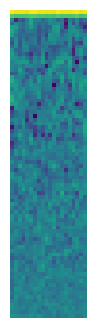

In [26]:
view_mel(snippet.detach().to("cpu").squeeze())

# Evaluation

In [41]:
# EVALUATION
# for now, metric is whether the transcription is empty or consists only of blank tokens

def evaluate(snippet, prepare_method, model, test_dataset):
    print(f"Clamp: {CLAMP_EP}\nPrepare Method: {prepare_method.name}")
    empty_counter = 0
    char_counter = 0
    total_examples = 0
    original_chars = 0

    snippet = snippet.to(device)
    pbar = tqdm(range(len(test_dataset)), desc="Inference")
    test_dataset_iter = iter(test_dataset)
    model.eval()

    for i in pbar:
        # evaluate if there are any words at all
        example, answer = next(test_dataset_iter).values()
        if isinstance(answer, tuple) or isinstance(answer, list):
            answer = answer[0]
        if answer != "ignore_time_segment_in_scoring":
            attacked_example = prepare_method(snippet, example.to(device))
            transcription = model.transcribe(attacked_example.squeeze(), language="en", condition_on_previous_text=False, fp16=True)["text"]

            if not transcription.strip():
                empty_counter += 1
            char_counter += len(transcription.strip())
            original_chars += len(answer)
            total_examples += 1
            pbar.set_postfix_str(f"Valid Examples: {total_examples} | Empty Sequences: {empty_counter} | Total SL = {char_counter}")

        example.to("cpu")

    pbar.close()
    print("\n")
    print(f"Total valid examples: {total_examples}")
    print(f"Success rate (Empty): {empty_counter/total_examples}")
    print(f"Success rate (ASL): {char_counter/total_examples} (attacked) out of {original_chars/total_examples} (original)")

evaluate(snippet, PREPARE_METHOD, model, test_dataset) # commented to prevent the runtime from autorunning and crashing the thing

Clamp: 0.02
Prepare Method: prepare_overlay_front


Inference: 100%|██████████| 250/250 [01:48<00:00,  2.30it/s, Valid Examples: 194 | Empty Sequences: 0 | Total SL = 23835]



Total valid examples: 194
Success rate (Empty): 0.0
Success rate (ASL): 122.86082474226804 (attacked) out of 122.16494845360825 (original)


In [ ]:
def normalise(random_snippet, ep):
    # we assume torch.rand inits to [0, 1)
    res = random_snippet * ep * 2 - ep
    print(f"Normalised, Min {torch.min(res)}, Max {torch.max(res)}")
    return res

# Save and Hear Snippet

In [48]:
# Save snippet to wav file
save_audio(snippet, f"./snippets/clamp_{CLAMP_EP}_{PREPARE_METHOD.name}_snippet_only.wav")

In [49]:
save_audio(PREPARE_METHOD(snippet.to("cpu"), tedlium_test[2]["audio"].unsqueeze(0)), f"./snippets/clamp_{CLAMP_EP}_{PREPARE_METHOD.name}_combined.wav")